# Table of contents
1. [Purpose](#purpose)
2. [Inputs](#inputs)
    * [2.1 SQL Database](#subinput1)
3. [Outputs](#outputs)
4. [Constraints](#constraints)
5. [Dependancies](#dependancies)
    * [5.1 Code Language](#subdependancy1)
      * [5.1.1 package requirements](#subsubdepenances)

6. [Code](#code)
    * [6.1 Management Summary](#code61)
    * [6.2 Protection Status Summary](#code62)
7. [Tests](#tests)
8. [Provenance](#provenance)
9. [Citations](#citations)
---

# National Vegetation Classification System (NVCS) Management and Protection Status Summarization
<br/>

## Purpose <a name="purpose"></a>
The USGS Gap Anaysis Program (GAP) and the USDA LANDFIRE working groups have developed land use/land cover datasets for the conterminous United States under the auspices of the vegetation sub-committe of the Federal Geographic Data Committe and the Ecolgoical Society of America's release of the US National Vegetation Classification (USNVC) version 2.01. The USNVC (or NVC) is an 8-level hierarchical classification of the native and non-native vegetation of the nation down to the species association level.

GAP has also produced a composite map of the protected areas witin the United States categorized at four levels of protection status (1-4). The Protected Areas Database (PAD) also contains data on management including manager name (eg. USDA Forest Service, county park, easement) and type (eg. federal, state, local, private).

Intersecting these two datasets facilitates assessment of the areal and spatial extent of protection across various vegetation classes and management throughout the country. This biological analysis package illustrates a readily available, repeatable, transparent and rapid process to conduct just such an assessment.

## Inputs <a name="inputs"></a>
The code in this notebook is intended to provide a summarization for NVCS classes for GAP Protected Areas Database (PAD) status levels 1, 2, and 3 across PAD mangement categories.
    
It utilizes an SQL server database assembled by intersecting numerous raster data layers created by the Gap Analysis Program including the PAD-US, species habitat maps, boundary layers such as states, counties, LCCs, ecoregions, etc. That database (the GAP Analytic database) at the time of this workflow development was only available on a local server. Hence, all code references a local instance of this database. This code is only replicable given access to a local instance of the database.

* ### SQL Database <a name="subinput1"></a>
This analysis utilizes the GAP Analytic database developed by Linda Scheuk, Anne Davidson, and Leah Dunn at Boise State University. Information about access to a given instance of this database is pending.

## Outputs <a name="outputs"></a>
Charts visualizing the areal extent of NVC classes by manager/manager type, and protection category.

## Constraints <a name="constraints"></a>
Constraints paragraph text

## Dependancies <a name="dependancies"></a>
Code execution and output visualization dependancies

* ### Code Language <a name="subdependancy1"></a>
This code is written in Python 3.x. Earlier versions may be compatible given slight alterations in syntax and package components.
  * #### Python package requirements <a name="subsubdepenances"></a>
  The required packages for proper code execution inlclude:
    - Pandas version 0.2x or above
    - pyodbc version 4.x or above
    - numpy version 1.14.x or above
    - seaborn (statistical data visualization package) version 0.8 or above
    - matplotlib (figures library) version2.2.x or above
    - bokeh (interactive HTML charting package) version 0.12.x or above


## Tests <a name="tests"></a>
Ideas on how this information may be utilized by stakeholders
* ??????????????????????????????????????????????

## Provenance <a name="provenance"></a>
Enter W3C PROV stuff here

## Code <a name="code"></a>
Python code cells for the workflow

#### Import required Python packages

In [2]:
import pyodbc
import pandas as pd
import numpy as np
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt

#### Accessing the local SQL server instance of the GAP Analytic database

In [3]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#            ++++ Directory Locations ++++
workDir = 'C:/Data/USGS Analyses/NVC-Analyses/Scripts/'


#############################################################################################
################################### LOCAL FUNCTIONS #########################################
#############################################################################################


## --------------Cursor and Database Connections--------------------

def ConnectToDB(connectionStr):
    '''
    (str) -> cursor, connection

    Provides a cursor within and a connection to the database

    Argument:
    connectionStr -- The SQL Server compatible connection string
        for connecting to a database
    '''
    try:
        con = pyodbc.connect(connectionStr)
    except:
        connectionStr = connectionStr.replace('11.0', '10.0')
        con = pyodbc.connect(connectionStr)

    return con.cursor(), con

## ----------------Database Connection----------------------

def ConnectAnalyticDB():
    '''
    Returns a cursor and connection within the GAP analytic database.
    '''
    # Database connection parameters
    dbConStr = """DRIVER=SQL Server Native Client 11.0;
                    SERVER=CHUCK\SQL2014;
                    UID=;
                    PWD=;
                    TRUSTED_CONNECTION=Yes;
                    DATABASE=GAP_AnalyticDB;"""

    return ConnectToDB(dbConStr)


#############################################################################################
#############################################################################################
#############################################################################################


In [4]:
## Connect to the Analytic Database
print("+"*45)
print("Connecting to Database ....")
cur, conn = ConnectAnalyticDB()

+++++++++++++++++++++++++++++++++++++++++++++
Connecting to Database ....


### ******* Management Summary ******* <a name="code61"></a>
---

#### Generating an SQL string to pass to a pandas dataframe

In [5]:
## The SQL to pull out NVC Classes, PAD management and status data from the analytic db
sql = """


SELECT
	padus1_4.gap_sts as PADStatus,
	padus1_4.d_mang_nam as ManageName,
	padus1_4.d_mang_typ as ManageType,
	gap_landfire.nvc_class as NVCClass,
	--gap_landfire.nvc_group as NVCGroup,
	sum(lu_boundary_gap_landfire.count) as nCells
FROM	lu_boundary INNER JOIN lu_boundary_gap_landfire INNER JOIN gap_landfire
	ON	lu_boundary_gap_landfire.gap_landfire = gap_landfire.value
	ON	lu_boundary.value = lu_boundary_gap_landfire.boundary INNER JOIN padus1_4
	ON	lu_boundary.padus1_4 = padus1_4.objectid
GROUP BY
  padus1_4.d_mang_nam,
  padus1_4.d_mang_typ,
  padus1_4.gap_sts, 
  gap_landfire.nvc_class
  --gap_landfire.nvc_group

"""

#### Passing the SQL and getting a pandas dataframe

In [6]:
# Make a dataframe from the results of the SQL query
print("Creating Initial Dataframe ....")
df = psql.read_sql(sql, conn)

Creating Initial Dataframe ....


In [7]:
df

,PADStatus,ManageName,ManageType,NVCClass,nCells
0,2,Private,Unknown,Agricultural & Developed Vegetation,1129
1,4,State Department of Natural Resources,State,Recently Disturbed or Modified,82242
2,4,State Land Board,State,Recently Disturbed or Modified,291191
3,4,Regional Agency Land,Regional Agency Special District,Agricultural & Developed Vegetation,14674
4,4,Department of Defense,Federal,Open Water,320325
5,3,American Indian Lands,American Indian Lands,Recently Disturbed or Modified,3277
6,2,Army Corps of Engineers,Federal,Agricultural & Developed Vegetation,44127
7,2,Natural Resources Conservation Service,State,Recently Disturbed or Modified,30
8,3,Tennessee Valley Authority,Federal,Forest & Woodland,890180
9,2,State Department of Land,State,Shrub & Herb Vegetation,10055


#### Pull out only the natural/non-anthropogenic NVC classes

In [8]:
# Pull out only the natural/non-anthropogenic NVC classes
print("Removing Anthropogenic Classes ....")
df2 = df[(df['NVCClass'] == 'Forest & Woodland') | 
         (df['NVCClass'] == 'Shrub & Herb Vegetation') | 
         (df['NVCClass'] == 'Desert & Semi-Desert') | 
         (df['NVCClass'] == 'Polar & High Montane Scrub, Grassland & Barrens') | 
         (df['NVCClass'] == 'Open Rock Vegetation')]

Removing Anthropogenic Classes ....


#### Add a new column for area in square kilometers -- (ignore the Python warnings)

In [9]:
# Add a new column for area in square kilometers
print("Calculating Area in km2 ....")
df2['km2'] = df2['nCells']*0.0009

Calculating Area in km2 ....


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Add a new column ManageCat that standarizes management types

In [10]:
# Add a new column ManageCat that standarizes management types
categories = {'Bureau of Land Management':'Bureau of Land Management',
'Forest Service':'Forest Service',
'National Park Service':'National Park Service',
'U.S. Fish & Wildlife Service':'U.S. Fish & Wildlife Service',
'American Indian Lands':'Other',
'City Land':'Other',
'County Land':'Other',
'Joint':'Other',
'Non-Governmental Organization':'Other',
'Other':'Other',
'Other or Unknown Local Government':'Other',
'Private':'Other',
'Regional Agency Land':'Other',
'Regional Water Districts':'Other',
'Unknown':'Other',
'Agricultural Research Service':'Other Federal',
'Army Corps of Engineers':'Other Federal',
'Bureau of Indian Affairs':'Other Federal',
'Bureau of Reclamation':'Other Federal',
'Department of Defense':'Other Federal',
'Department of Energy':'Other Federal',
'National Oceanic and Atmospheric Administration':'Other Federal',
'Other or Unknown Federal Land':'Other Federal',
'Tennessee Valley Authority':'Other Federal',
'Natural Resources Conservation Service':'Other Federal',
'Other or Unknown State Land':'State',
'State Department of Conservation':'State',
'State Department of Land':'State',
'State Department of Natural Resources':'State',
'State Fish and Wildlife':'State',
'State Land Board':'State',
'State Park and Recreation':'State'}
print("Adding a Management Category Column ....")
df2['ManageCat'] = df2['ManageName'].map(categories)

Adding a Management Category Column ....


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Remove the PAD status 4 records and shorten the "Polar" class text

In [11]:
# Make a new dataframe excluding PAD status 4 records
df3 = df2[(df2['PADStatus'] != '4')]
# Shorten the class text 'Polar & High Montane Scrub, Grassland & Barrens'
#  to 'Polar & High Montane' for better plotting
df3['NVCClass'] = np.where(df3['NVCClass']==
   'Polar & High Montane Scrub, Grassland & Barrens',
   'Polar & High Montane', df3['NVCClass'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Import the bokeh package for plotting and then start manipulating and organizing the data to prepare it as the data source for a bar chart figure

In [12]:
'''

    Plot stacked bar plots

'''
print("===== Begin Plotting =====")
# Using bokeh to plot with hierarchical labeling
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter, HoverTool

# Bokeh generates an HTML file for the figure
output_file(workDir + "ManagementSummary.html")

===== Begin Plotting =====


In [13]:
# -----------------------------------------------------------------------------
# Manipulate the dataframe to organize data to use as the plotting source

# Add a Status column based on PAD Status to summarize area protection
print("  adding protection status column ...")
df3['Status'] = np.where(df3['PADStatus']=='3', 'Multiple Use', 'Protected')

# Drop PADStatus, ManageName, and nCellSum
df3 = df3.drop(['PADStatus','ManageName','nCells'], axis=1)
# There is no entry of 'Protected' (i.e. status 1 and/or 2) for Polar & High Montane
#   - 'Other Federal' in the data making the records for status pairs uneven.
#  Add a row that is 0 for these criteria
dfa = pd.DataFrame([['Polar & High Montane',0.0,'Other Federal','Protected']],
                   columns=['NVCClass','km2','ManageCat','Status'])
df3 = df3.append(dfa, ignore_index=True)

# Summarize protection area by category, class, and status
print("  summarizing by protection area by category, class and status ...")
dfSumKm = df3.groupby(by=['ManageCat','NVCClass','Status'])['km2'].sum().reset_index()
# Make a column of tupled category and class to index off
dfSumKm['CatCls'] = list(zip(dfSumKm['ManageCat'], dfSumKm['NVCClass']))
# Drop ManageCat and NVCClass columns
dfSumKm = dfSumKm.drop(['ManageCat','NVCClass'], axis=1)

# Pivot on Status and make the tupled category and class column the index
print("  pivoting on status column ...")
df4 = dfSumKm.pivot(index='CatCls', columns='Status', values='km2')
# Reorder columns
df4 = df4[['Protected', 'Multiple Use']]

# Reorder the rows using a preset order dictionary
print("  reordering rows ...")
sort = {('Bureau of Land Management', 'Forest & Woodland'):1,
('Bureau of Land Management', 'Shrub & Herb Vegetation'):2,
('Bureau of Land Management', 'Desert & Semi-Desert'):3,
('Bureau of Land Management', 'Polar & High Montane'):4,
('Bureau of Land Management', 'Open Rock Vegetation'):5,
('Forest Service', 'Forest & Woodland'):6,
('Forest Service', 'Shrub & Herb Vegetation'):7,
('Forest Service', 'Desert & Semi-Desert'):8,
('Forest Service', 'Polar & High Montane'):9,
('Forest Service', 'Open Rock Vegetation'):10,
('National Park Service', 'Forest & Woodland'):11,
('National Park Service', 'Shrub & Herb Vegetation'):12,
('National Park Service', 'Desert & Semi-Desert'):13,
('National Park Service', 'Polar & High Montane'):14,
('National Park Service', 'Open Rock Vegetation'):15,
('U.S. Fish & Wildlife Service', 'Forest & Woodland'):16,
('U.S. Fish & Wildlife Service', 'Shrub & Herb Vegetation'):17,
('U.S. Fish & Wildlife Service', 'Desert & Semi-Desert'):18,
('U.S. Fish & Wildlife Service', 'Polar & High Montane'):19,
('U.S. Fish & Wildlife Service', 'Open Rock Vegetation'):20,
('Other Federal', 'Forest & Woodland'):21,
('Other Federal', 'Shrub & Herb Vegetation'):22,
('Other Federal', 'Desert & Semi-Desert'):23,
('Other Federal', 'Polar & High Montane'):24,
('Other Federal', 'Open Rock Vegetation'):25,
('State', 'Forest & Woodland'):26,
('State', 'Shrub & Herb Vegetation'):27,
('State', 'Desert & Semi-Desert'):28,
('State', 'Polar & High Montane'):29,
('State', 'Open Rock Vegetation'):30,
('Other', 'Forest & Woodland'):31,
('Other', 'Shrub & Herb Vegetation'):32,
('Other', 'Desert & Semi-Desert'):33,
('Other', 'Polar & High Montane'):34,
('Other', 'Open Rock Vegetation'):35}

# Make a new dataframe by resetting the df4 index
df5 = df4.reset_index()
# Add the sortid column for sorting then sort
df5['sortid'] = df5['CatCls'].map(sort)
df5sort = df5.sort_values(by='sortid')
# Drop the sortid column then change the index back to CatCls
dfSource = df5sort.drop(['sortid'],axis=1)
dfSource = dfSource.set_index(keys=['CatCls'])
# Add a total km2 column
dfSource['Total Area'] = dfSource['Protected'] + dfSource['Multiple Use']

  adding protection status column ...
  summarizing by protection area by category, class and status ...
  pivoting on status column ...
  reordering rows ...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


#### Configure the data and create an HTML file of the stacked bar chart

Note that the HTML file of the bar chart figure is interactive. There is a toolbar on the right side of the chart area.

In [14]:
# +++++++++++++++++++++++++++++++++++++++ Plotting +++++++++++++++++++++++++++++++++++++++++++++++++++
print("+++++ Sending Plot to HTML File +++++")
colors = ['#286000','#a6e883'] # Protected | Multiple Use
p = figure(title="Management by USNVC Class", plot_width=1100, x_range=FactorRange(*dfSource.index))

tt = HoverTool(
tooltips=[
    ("Protected", "@Protected{0,0}"),
    ("Multiple Use", "@{Multiple Use}{0,0}"),
    ("Total", "@{Total Area}{0,0}")
    ]
)

p.vbar_stack(dfSource.columns[0:2], x='CatCls', width=0.8, color=colors, 
             source=dfSource, legend=[value(x) for x in dfSource.columns[0:2]]) 

p.add_tools(tt)
p.title.align = "center"
p.title.text_font_size = '12pt'
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
p.xaxis.major_label_orientation = 1.55
p.xaxis.axis_label_text_font_style = "normal"
p.y_range.start = 0
p.y_range.end = 150000
p.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p.yaxis.axis_label = "Square Kilometers"
p.yaxis.axis_label_text_font_style = "normal"

show(p)

+++++ Sending Plot to HTML File +++++


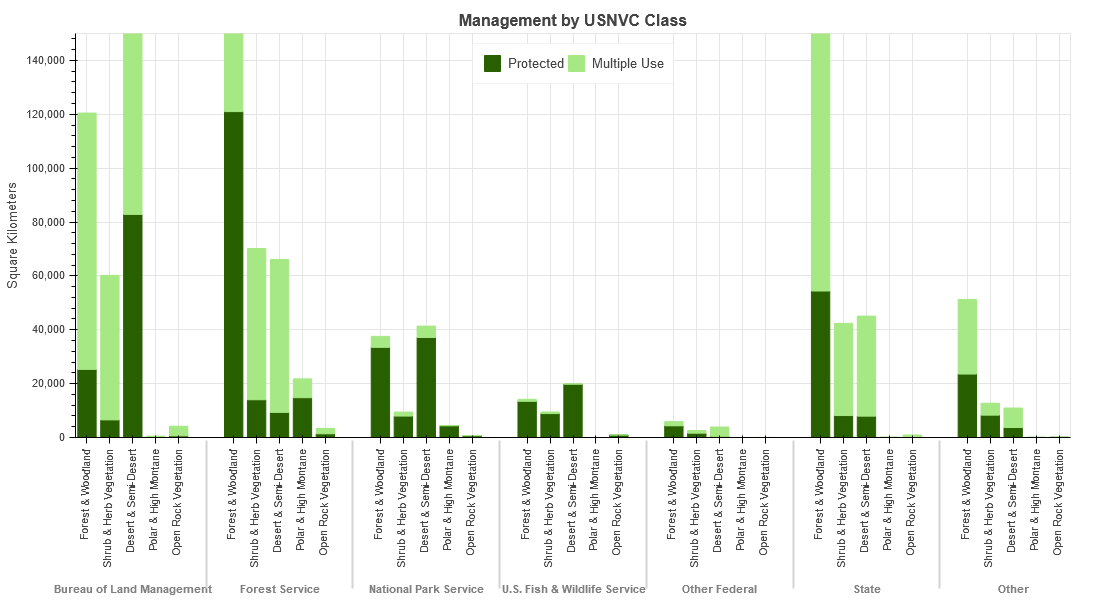

In [15]:
# The following will render the HTML file in the notebook using a local file source
from IPython.core.display import display, HTML, Image
#display(HTML(filename=workDir + "/ManagementSummary.html"))
# To display this on GitHub, render a screenshot image
repoDir = "C:/Data/USGS Analyses/NVC-Analyses"
display(Image(filename=repoDir + '/ManagementSummaryImage.png', embed=True))

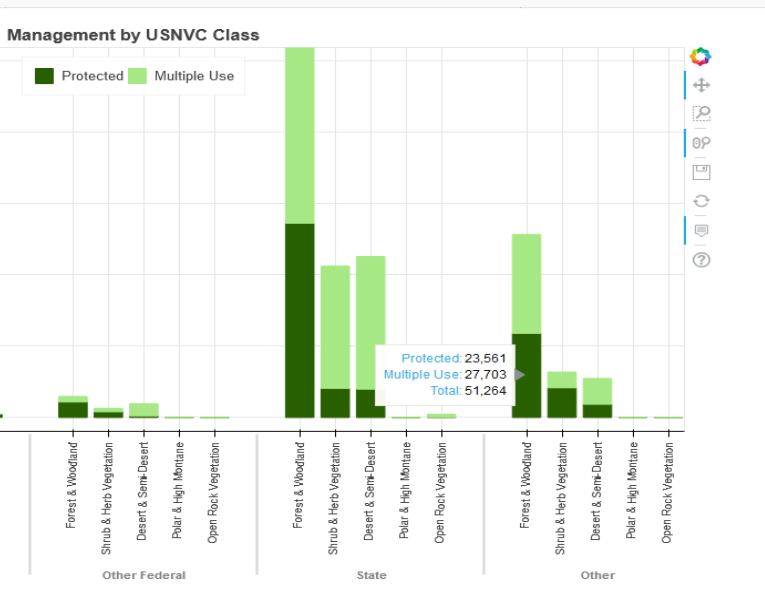

In [16]:
display(Image(filename=repoDir + '/BokehPlotZoom.png', embed=True))

### ******* Protection Status Summary ******* <a name="code62"></a>
---

#### Generate an SQL that summarizes NVC Groups, Classes, and PAD Status

In [18]:
## The SQL to pull out NVC Groups, Classes and PADUS data from the analytic db
sql = """

WITH

/*
	Summarization of total cells within each NVCS Group
*/

NVC_GroupTotal AS (
SELECT 
	gap_landfire.nvc_group,
	sum(lu_boundary_gap_landfire.count) as nGroupTotalCells
FROM	lu_boundary INNER JOIN lu_boundary_gap_landfire INNER JOIN gap_landfire
	ON		lu_boundary_gap_landfire.gap_landfire = gap_landfire.value
	ON		lu_boundary.value = lu_boundary_gap_landfire.boundary
GROUP BY
  gap_landfire.nvc_group

),


/*
	Summary by PAD status for NVCS Groups
*/
NVC_Group AS (  
SELECT
	padus1_4.gap_sts as PADStatus, 
	gap_landfire.nvc_class as NVCClass,
	gap_landfire.nvc_group as NVCGroup,
	sum(lu_boundary_gap_landfire.count) as nCells,
	sum(lu_boundary_gap_landfire.count) * 0.0009 as km2
FROM	lu_boundary INNER JOIN lu_boundary_gap_landfire INNER JOIN gap_landfire
	ON	lu_boundary_gap_landfire.gap_landfire = gap_landfire.value
	ON	lu_boundary.value = lu_boundary_gap_landfire.boundary INNER JOIN padus1_4
	ON	lu_boundary.padus1_4 = padus1_4.objectid
GROUP BY
  padus1_4.gap_sts, 
  gap_landfire.nvc_class,
  gap_landfire.nvc_group

)

/*
	Assemblying data in single output and pivoting on status
*/

	SELECT *
	FROM
	(
	SELECT NVC_Group.PADStatus,
			NVC_Group.NVCClass,
			NVC_Group.NVCGroup,
			NVC_GroupTotal.nGroupTotalCells,
			NVC_Group.nCells
	FROM   NVC_GroupTotal INNER JOIN NVC_Group 
	ON	   NVC_GroupTotal.nvc_group = NVC_Group.NVCGroup
	) AS NVC_Output

	PIVOT
	(
		MAX(NVC_Output.nCells)
		FOR NVC_Output.PADStatus IN ([1], [2], [3], [4])
	) piv
	ORDER BY NVCGroup

"""


#### Pass the SQL to get a Pandas dataframe

In [19]:
# Make a dataframe from the results of the SQL query
df = psql.read_sql(sql, conn)

# Fill all the empty values with 0 and rename columns
df['PAD1'] = df['1'].fillna(0)
df['PAD2'] = df['2'].fillna(0)
df['PAD3'] = df['3'].fillna(0)


# Drop the original PAD status columns
df = df.drop('1', axis=1)
df = df.drop('2', axis=1)
df = df.drop('3', axis=1)
df = df.drop('4', axis=1)


# Recalcute PAD status 4 cell counts for NVC groups using the category
# totals and the sum of status 1 to 3 cell counts
df['PAD4'] = df['nGroupTotalCells'] - (df['PAD1'] + df['PAD2'] + df['PAD3'])

# Calculate area in km2
df['PAD1 km2'] = df['PAD1'] * 0.0009
df['PAD2 km2'] = df['PAD2'] * 0.0009
df['PAD3 km2'] = df['PAD3'] * 0.0009
df['PAD4 km2'] = df['PAD4'] * 0.0009


# Calculate percentages
df['% Protected 1 & 2'] = ((df['PAD1'] + df['PAD2'] ) / df['nGroupTotalCells']) * 100
df['% Protected 1, 2 & 3'] = ((df['PAD1'] + df['PAD2'] + df['PAD3']) / df['nGroupTotalCells']) * 100


In [20]:
df

,NVCClass,NVCGroup,nGroupTotalCells,PAD1,PAD2,PAD3,PAD4,PAD1 km2,PAD2 km2,PAD3 km2,PAD4 km2,% Protected 1 & 2,"% Protected 1, 2 & 3"
0,Forest & Woodland,Appalachian Central Interior Mesic Forest,93498258,1112730.0,3456038.0,5423844.0,83505646.0,1001.4570,3110.4342,4881.4596,75155.0814,4.886474,10.687485
1,Shrub & Herb Vegetation,Appalachian Mafic Glade,90,0.0,51.0,0.0,39.0,0.0000,0.0459,0.0000,0.0351,56.666667,56.666667
2,Forest & Woodland,Appalachian Oak / Chestnut Forest,122684952,3173985.0,5198432.0,16635805.0,97676730.0,2856.5865,4678.5888,14972.2245,87909.0570,6.824323,20.384099
3,Forest & Woodland,Appalachian-Allegheny Northern Hardwood - Coni...,68819751,1661971.0,1723112.0,14374212.0,51060456.0,1495.7739,1550.8008,12936.7908,45954.4104,4.918767,25.805521
4,Shrub & Herb Vegetation,Arid West Interior Freshwater Marsh,4489004,202808.0,955566.0,567215.0,2763415.0,182.5272,860.0094,510.4935,2487.0735,25.804700,38.440353
5,Shrub & Herb Vegetation,Atlantic & Gulf Coast Fresh-Oligohaline Tidal ...,1196644,27028.0,333808.0,64826.0,770982.0,24.3252,300.4272,58.3434,693.8838,30.153997,35.571314
6,Shrub & Herb Vegetation,Atlantic & Gulf Coastal Brackish Tidal Marsh,292233,1371.0,57618.0,34712.0,198532.0,1.2339,51.8562,31.2408,178.6788,20.185605,32.063798
7,Shrub & Herb Vegetation,Atlantic & Gulf Coastal High Salt Marsh,24702655,1472498.0,4113341.0,1901684.0,17215132.0,1325.2482,3702.0069,1711.5156,15493.6188,22.612302,30.310600
8,Shrub & Herb Vegetation,Atlantic & Gulf Coastal Interdunal Marsh & Wet...,2502,540.0,772.0,380.0,810.0,0.4860,0.6948,0.3420,0.7290,52.438050,67.625899
9,Shrub & Herb Vegetation,Atlantic & Gulf Coastal Plain Pondshore & Wet ...,1568855,79575.0,126717.0,359392.0,1003171.0,71.6175,114.0453,323.4528,902.8539,13.149208,36.057124


Now we need to do some manipulation of the % protected data to calculate how many NVC groups fall into the protected bins:
* < 1%
* 1-17%
* 17-50%
* \> 50%

Then, these groups need to be summarized by NVC class (there are 12) EXCLUDING the anthropogenic and non-vegetaion classes:
* Recently Disturbed or Modified
* Open Water
* Nonvascular & Sparse Vascular Rock Vegetation
* Agricultural & Developed Vegetation
* Developed & Other Human Use
* Introduced & Semi Natural Vegetation
* Aquatic Vegetation

That leaves the following NVC classes remaining to summarize protection status percentages:
* Desert & Semi-Desert
* Forest & Woodland
* Open Rock Vegetation
* Polar & High Montane Scrub, Grassland & Barrens
* Shrub & Herb Vegetation

In [22]:
lt1 = len(df[df['% Protected 1 & 2'] < 1])
lt17 = len(df[(df['% Protected 1 & 2'] > 1) & (df['% Protected 1 & 2'] < 17)])
lt50 = len(df[(df['% Protected 1 & 2'] > 17) & (df['% Protected 1 & 2'] < 50)])
gt50 = len(df[df['% Protected 1 & 2'] > 50])

print('Number of NVC groups with less than 1 % protection = ', lt1)
print('Number of NVC groups with more than 1 % and less than 17% protection = ', lt17)
print('Number of NVC groups with more than 17 % and less than 50% protection = ', lt50)
print('Number of NVC groups with more than 50 % protection = ', gt50)

Number of NVC groups with less than 1 % protection =  12
Number of NVC groups with more than 1 % and less than 17% protection =  159
Number of NVC groups with more than 17 % and less than 50% protection =  58
Number of NVC groups with more than 50 % protection =  20


In [23]:
DsDlt1 = len(df[(df['% Protected 1 & 2'] < 1) & (df['NVCClass'] == 'Desert & Semi-Desert')])
print('Number of groups in Desert & Semi-desert class with less than 1% protection:', DsDlt1)

FWlt17 = len(df[(df['% Protected 1 & 2'] > 1) & (df['% Protected 1 & 2'] < 17) & (df['NVCClass'] == 'Forest & Woodland')])
print('Number of groups in Forest and Woodland class with less than 17% protection:', FWlt17)

Number of groups in Desert & Semi-desert class with less than 1% protection: 2
Number of groups in Forest and Woodland class with less than 17% protection: 87


Start manipulating the data to:
* Exclude the anthropogenic and non-vegetation classes
* Limit the columns to only the percent protection status amounts for each class
* Pivot the data to assist in plotting

In [24]:
df2 = df[['NVCClass','NVCGroup','% Protected 1 & 2','% Protected 1, 2 & 3']]
# Pull out only the natural/non-anthropogenic NVC classes
df3 = df2[(df2['NVCClass'] == 'Forest & Woodland') | 
				(df2['NVCClass'] == 'Shrub & Herb Vegetation') | 
				(df2['NVCClass'] == 'Desert & Semi-Desert') | 
				(df2['NVCClass'] == 'Polar & High Montane Scrub, Grassland & Barrens') | 
				(df2['NVCClass'] == 'Open Rock Vegetation')]

# Re-orient the dataframe to generate boxplots for each NVC class
df3_melt = df3.melt(id_vars = 'NVCClass',
                  value_vars = ['% Protected 1 & 2',
                                '% Protected 1, 2 & 3'],
                  var_name = 'Percent Protected',
                  value_name = 'Percent of Mapped Area')


In [25]:
df3_melt.head(5)

,NVCClass,Percent Protected,Percent of Mapped Area
0,Forest & Woodland,% Protected 1 & 2,4.886474
1,Shrub & Herb Vegetation,% Protected 1 & 2,56.666667
2,Forest & Woodland,% Protected 1 & 2,6.824323
3,Forest & Woodland,% Protected 1 & 2,4.918767
4,Shrub & Herb Vegetation,% Protected 1 & 2,25.804700


In [26]:
df3_melt.tail(5)

,NVCClass,Percent Protected,Percent of Mapped Area
471,Forest & Woodland,"% Protected 1, 2 & 3",44.842023
472,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",64.145211
473,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",76.036953
474,Shrub & Herb Vegetation,"% Protected 1, 2 & 3",64.160524
475,Forest & Woodland,"% Protected 1, 2 & 3",17.932157


Finally, plot the data using a boxplot (using the Seaborn statistical visualization package) where classes are on the x-axis and protection status levels (1 & 2 and 1, 2, & 3) are paired together in the plot.

There are numerous formatting options available in matplotlib, a few are utilized here.

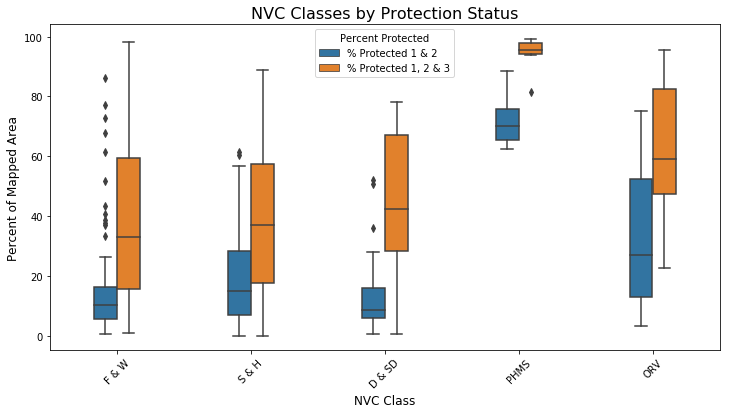

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(rotation=45)
a = sns.boxplot(data = df3_melt,
                hue = 'Percent Protected',
                x = 'NVCClass',
                y = 'Percent of Mapped Area',
                order = ['Forest & Woodland',
                         'Shrub & Herb Vegetation',
                         'Desert & Semi-Desert',
                         'Polar & High Montane Scrub, Grassland & Barrens',
                         'Open Rock Vegetation'],
                width=0.35,
                ax=ax)
a.set_xlabel('NVC Class', fontsize=12)
a.set_ylabel('Percent of Mapped Area', fontsize=12)
labels = ['F & W','S & H','D & SD','PHMS','ORV']
a.set_xticklabels(labels)
a.set_title('NVC Classes by Protection Status', fontsize=16)

plt.show()


## Citations <a name="citations"></a>
Aycrigg, J. L., Davidson, A., Svancara, L. K., Gergely, K. J., McKerrow, A.J., & Scott, M. (2013). Representation of ecological systems within the protected areas network of the continental United States. PLoSONE, 8(1), e54689. https://doi.org/10.1371/journal.pone.0054689

U.S. Geological Survey, Gap Analysis Program. (2016). Protected Areas Database of the United States (PAD-US), version 1.4 Combined Feature Class. https://doi.org/10.5066/F7G73BSZ